# PSB and ESR

Combination of `august/ESR.ipynb`, `august/pauli.ipynb` and `august/pauli_plots.ipynb`

In [7]:
%matplotlib inline
import local_broom

In [8]:
# Automagically reload modules when they are edited
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time
import logging
from monty import Monty
from liveplot import LivePlot

from qcodes import Instrument, Station
import MDAC
from fridge import Fridge
from shfqc import SHFQC
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.agilent.E8267C import E8267
from may.dots import getvoltages
from may.custom_devices import connect_to_gb, newSiDot

# Change these to match the experiment
import psb as paul
import esr

In [46]:
234

234

## Connect

In [10]:
channels = ["ST", "P1", "P2", "J"]
channel_addr = [0, 1, 2, 3]

# channels = ["ST", "P1", "P2", "J", "MW"]
# channel_addr = [4, 0, 2, 3, 5]

# channels = ["MW"]
# channel_addr = [5]

shfqc = SHFQC(channels, channel_addr, "measure")
shfqc.connect()
shfqc.desync()

Connecting to device DEV12158
Creating new command tables


In [91]:
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')

try:
    lockin = Instrument.find_instrument("lockin")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name lockin. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

#lockin = scfg.load_instrument('sr860_top')
#psg = scfg.load_instrument('PSG')

lockin = SR860('lockin', 'TCPIP::192.168.0.108::inst0::INSTR')
psg = E8267('psg', 'TCPIP0::192.168.0.109::inst0::INSTR')


gb_control_si = connect_to_gb(mdac)  # Create our custom MDAC mappings
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Attempting to remove instrument with name mdac. Does not exist


This Driver is for Version 1.5-1.7, 
please use updated QCoDeS driver
  warnings.warn(error_str)



Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.19s
Cannot remove instrument with name lockin. Does not exist
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.12s
Connected to: Agilent Technologies E8267D (serial:US50420058, firmware:C.06.25) in 0.08s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [6]:
shfqc.disconnect()

Disconnecting from device DEV12158


Disconnect. Run with caution

In [11]:
# Disconnect from all devices
disconnect = True
if disconnect:
    shfqc.disconnect()
    try:
        mdac = Instrument.find_instrument("mdac")
        mdac.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')
    try:
        lockin = Instrument.find_instrument("lockin")
        lockin.close()
    except KeyError:
        print("Cannot remove instrument with name sr860_top. Does not exist")
    try:
        psg = Instrument.find_instrument("psg")
        psg.close()
    except KeyError:
        print('Attempting to remove instrument with name mdac. Does not exist')

Disconnecting from device DEV12158
Attempting to remove instrument with name mdac. Does not exist
Cannot remove instrument with name sr860_top. Does not exist
Attempting to remove instrument with name mdac. Does not exist


In [6]:
# setup monty
experiment = {
    "desc": "Run ESR frequency sweeps and PSB detuning / J sweeps"
}

monty = Monty("rf.esr_and_psb", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 54


## Define parameters

Run either PSB parameters or ESR parameters but not both.

### PSB PARAMETERS

In [5]:
psb_params = {
    "amplitude_volts": {  # define the amplitudes that should be used. (maximum 340mV, give in Volts)
        "mixed_pulse": {  # voltage amplitude for mixed state preperation
            "P1": -0.2, #0.18,  # make sure keys match drive lines above
            "P2": 0.2, #0.18,
        },
        "measure_pulse_start": {  # voltages for stepping over when sweeping
            "P1": 0.02,
            "P2": -0.02,
            "J": 0,
        },
        "measure_pulse_end": {
            "P1": -0.05,
            "P2": 0.05,
            "J": 0,
        },
        "ramp_rate": 13e-5,  # V/sample
    },
    "readout": {
        "freq": 406.6e6,  # (Hz) try 406.2e6
        "gain": 0.95,  # If we set this to 1, then output overloads
        "time": 100e-6,  # sec
    },
    "timings_sec": {  # all in seconds
        "mixed_initilise": 600e-6,
        "read": 100e-6,
        "settle": 3e-3,
        "trigger": 8e-3,  # metronome of the internal trigger
        "buffer": 10e-6,
        "sampling_divider": 6,  # playback waveform resolution 2^X
    },
    "feedback": {
        "target": -24.1,  # in dB
        "stepsize": 2e-2,  # arbitrary units
        "slope": -0,  # -1, 1 depending on slope, 0 to disable feedback
    },
    "powers": {  # in dB presets from UI
        "acq_in": 10,
        "acq_out": -10,
        "drive": 0, 
    },
    "averaging": {
        "seqc_averages": 200,  # max 2**19 points
        "num_detuning": 101,
        "num_j": 1,
    },
    "gates": getvoltages(mdac),
    "temp": f"Mixing chamber {fridge.temp()} K",
}


# Dynamic variables
# create arrays of our sweeping paramters
psb_j_steps = np.linspace(psb_params["amplitude_volts"]["measure_pulse_start"]["J"],
                      psb_params["amplitude_volts"]["measure_pulse_end"]["J"],
                      psb_params["averaging"]["num_j"])
psb_p1_steps = np.linspace(psb_params["amplitude_volts"]["measure_pulse_start"]["P1"],
                       psb_params["amplitude_volts"]["measure_pulse_end"]["P1"],
                       psb_params["averaging"]["num_detuning"])
psb_p2_steps = np.linspace(psb_params["amplitude_volts"]["measure_pulse_start"]["P2"],
                       psb_params["amplitude_volts"]["measure_pulse_end"]["P2"],
                       psb_params["averaging"]["num_detuning"])

NameError: name 'mdac' is not defined

### ESR PARAMETERS

In [95]:
esr_params = {
    "amplitude_volts": {  # define the amplitudes that should be used. (maximum 340mV, give in Volts)
        "mixed_pulse": {  # voltage amplitude for mixed state preperation
            "P1": -0.2,  # make sure keys match drive lines above
            "P2": 0.2,
        },
        "readout_pulse": {
            "P1": -0.0025,  #-0.0025,
            "P2": 0.0025,  #0.0025,
            "J": 0.000025,
        },
        "ramp_rate": 13e-5,  # V/sample
    },
    "sweep_j": {
        "j_start": -0.15,
        "j_stop": -0.15,
    },
    "sweep_detuning": {
        "p1_start": -0.0015,
        "p1_stop": -0.0035,
        "p2_start": 0.0015,
        "p2_stop": 0.0035,
    },
    "readout": {
        "freq": 406.6e6,  # (Hz) try 406.2e6
        "gain": 0.95,  # If we set this to 1, then output overloads
        "time": 100e-6,  # sec
    },
    "mw": {  # Microwave ESR settings
        "freqs": {  # (Hz)
            "center": 1.0e9,  # 1.5e9,
            "start": 0, #  -400e6,
            "stop": 0, #  400e6,
            # steps determined by averaging/num_freqs
        },
        "psgfreqstart": 6.5e9,  # using upper sideband
        "psgfreqstop": 6.8e9,  # using upper sideband
        "gain": 0.8,  # If we set this to 1, then output overloads
        "span": 1e6,  # frequency span for chirp signal, if enabled
        "sampling_divider": 3,
    },
    "timings_sec": {  # all in seconds
        "mixed_initilise": 600e-6,
        "read": 100e-6,
        "settle": 3e-3,
        "trigger": 8e-3,  # metronome of the internal trigger
        "buffer": 10e-6,
        "mw_pulse": 100e-6,
        "sampling_divider": 6,  # playback waveform resolution 2^X
    },
    "powers": {  # in dB presets from UI
        "acq_in": 10,
        "acq_out": -10,
        "drive": 0,  # only 0 is supported
        "mw_drive": 0,  # conncted to to PSG
        "psg_drive": 0,  # just a guess for now, output of psg
    },
    "averaging": {
        "seqc_averages": 200,  # max 2**19 points
        "num_freqs": 601,
        "num_j": 1,
        "num_detuning": 50,
    },
    "gates": getvoltages(mdac),
    "temp": f"Mixing chamber {fridge.temp()} K",
}


# Dynamic variables
# create arrays of our sweeping paramters
# freq_steps = np.linspace(params["mw"]["freqs"]["start"],
#                     params["mw"]["freqs"]["stop"],
#                     params["averaging"]["num_freqs"])

esr_freq_steps = np.linspace(esr_params["mw"]["psgfreqstart"],
                    esr_params["mw"]["psgfreqstop"],
                    esr_params["averaging"]["num_freqs"])
esr_j_steps = np.linspace(esr_params["sweep_j"]["j_start"],
                    esr_params["sweep_j"]["j_stop"],
                    esr_params["averaging"]["num_j"])
esr_p1_steps = np.linspace(esr_params["sweep_detuning"]["p1_start"],
                    esr_params["sweep_detuning"]["p1_stop"],
                    esr_params["averaging"]["num_detuning"])
esr_p2_steps = np.linspace(esr_params["sweep_detuning"]["p2_start"],
                    esr_params["sweep_detuning"]["p2_stop"],
                    esr_params["averaging"]["num_detuning"])

In [101]:
shfqc.drive_channels

['ST', 'P1', 'P2', 'J']

## Measure PSB

In [148]:
def sweep_j_and_detuning(params, p1_steps, p2_steps, j_steps):
    """2D parameter sweep of J and P1/P2 in detuning setup. Can measure PSB if mixed state preperation amplitude is not zero"""
    monty.newrun("j_and_detuning", params)

    # setup channels to match parameters
    paul.setupchannels(shfqc, params)
    paul.setupsequencers(shfqc, params, print_programs=False)
    paul.setup_command_tables(shfqc, params)
    time.sleep(1)  # wait to make sure everything processed in time

    # work out what we should be doing for feedback
    print("Measuring initial feedback point")
    paul.synchchannels(shfqc, [shfqc.qa_channel_name])
    with shfqc.device.set_transaction():
        
        shfqc["measure"].spectroscopy.result.length(1)
        seqc_program_prior_read = f"""
            repeat({params["averaging"]["seqc_averages"]}) {{
                waitDigTrigger(1);
        
                setTrigger(1);
                setTrigger(0);
            }}
            """
        shfqc["measure"].generator.load_sequencer_program(seqc_program_prior_read)
    
    time.sleep(1)
    shfqc["measure"].spectroscopy.result.length.wait_for_state_change(1, timeout=10)  # wait for changes to propagate
    
    data = paul.run_empty_experiment(shfqc)

    # run the real experiment
    paul.synchchannels(shfqc, [shfqc.qa_channel_name, "ST", "P1", "P2", "J"])
    paul.setupsequencers(shfqc, params, print_programs=False)  # reload original QA code
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_j"], params["averaging"]["num_detuning"], 2), dtype=np.complex64)
    st_result = np.zeros(result.shape, dtype=np.float64)
    
    print("Sweeping P1, P2 and J")
    for i, j in enumerate(tqdm(j_steps, desc="J")):
        #with LivePlot(p1_steps, xlabel="P1 voltage (dV)", ylabel="Amplitude (dB)") as lplot: 
        
        for k, (p1, p2) in enumerate(zip(tqdm(p1_steps, leave=False, desc="Detuning"), p2_steps)):
            paul.movemeasurement(shfqc, p1, p2, j, params)  # Use cmd index = 1
            #st_result[i, k] = paul.calculate_feedback(shfqc, data[-1], params)  # cmd index = 0
            paul.upload_command_tables(shfqc)
            data = paul.run_psb_experiment(shfqc)
            result[i, k] = data
            #lplot.update(autodb(result[i, :, 1]))
        monty.snapshot({"data": result, "st_result": st_result})

    results = {"data": result, "st_result": st_result}
    monty.save(results)


def hyper_j_sweep(params, j_steps):
    """
    Sweep j and detuning quickly by offloading as much as possible on the SHFQC device.
    Unforrtunately in this regime it is impossible to do feedback during detuning (although it can be done over J)
    """
    monty.newrun("hyper_j", params)

    if "feedback" in params.keys():
        logging.warning("Feedback specified in params but not used in this experiment")

    # setup channels for hyper sweeps
    paul.setupchannels(shfqc, params, hyper=True)
    paul.setup_hyper_sequencers(shfqc, params, print_programs=False)
    paul.setup_hyper_command_tables(shfqc, params)
    paul.upload_command_tables(shfqc, chans=["P1", "P2"])
    
    # run the real experiment
    paul.synchchannels(shfqc, [shfqc.qa_channel_name, "P1", "P2", "J"])
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_j"], params["averaging"]["num_detuning"]*2), dtype=np.complex64)
    
    print("Sweeping J (python), P1/P2 (seqc)")
    for i, j in enumerate(tqdm(j_steps, desc="J")):
        #gb_control_si.VICL(j)
        #gettotarget()
        time.sleep(1)
        #paul.move_j_measurement(shfqc, j, params)
        
        result[i, :] = paul.run_hyper_psb_experiment(shfqc)
        # update J command table
        monty.snapshot({"data": result})

    results = {"data": result}
    monty.save(results)

# Use plots.ipynb for plotting code based on the run number

In [149]:
shfqc.desync()
# sweep_j_and_detuning(psb_params, psb_p1_steps, psb_p2_steps, psb_j_steps)
hyper_j_sweep(psb_params, psb_j_steps)

Started new run hyper_j.61


Sweeping J (python), P1/P2 (seqc)


J:   0%|          | 0/1 [00:00<?, ?it/s]

Internal trigger:   0%|          | 0/100 [00:00<?, ?it/s]

Run finished and took 0:02:50.227617.
Saving to hyper_j.61.xz
Saving to experiment.yaml


In [138]:
# si.P1(1.805204)

In [139]:
# si.P2(1.919703)

In [150]:
# si.ST(3.677)

In [153]:
# gb_control_si.VICL()

In [12]:
import converter

In [38]:
converter.volt_to_arbitrary(0.5, 5)*1*0.177

0.15737772778844467

In [28]:
 np.sqrt(2 * 10**(10/10) * 1e-3 * 50)

1.0

## ESR Measurements

In [193]:
def sweep_esr_freq(params, freq_steps):
    """1D ESR frequency sweep"""
    monty.newrun("freq_sweep", params)

    # setup channels to match parameters
    esr.setupchannels(shfqc, params)
    esr.setupsequencers(shfqc, params, print_programs=False)
    esr.setup_command_tables(shfqc, params)
    time.sleep(1)  # wait to make sure everything processed in time

    # run the real experiment
    esr.synchchannels(shfqc, [shfqc.qa_channel_name, "P1", "P2", "J", "MW"])
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_freqs"], 2), dtype=np.complex64)

    # upload command tables
    p1 = params["amplitude_volts"]["readout_pulse"]["P1"]
    p2 = params["amplitude_volts"]["readout_pulse"]["P2"]
    j_g = params["amplitude_volts"]["readout_pulse"]["J"]
    mw_gain = params["mw"]["gain"]
    esr.movemeasurement(shfqc, p1, p2, j_g, mw_gain, params)  # set amplitudes

    esr.change_mw_freq(shfqc, params)  # reupload sequence with new waveform
    esr.upload_command_tables(shfqc)

    # strange bug somewhere, quick fix
    synth = shfqc['MW'].synthesizer()
    shfqc.device.synthesizers[synth].centerfreq(params["mw"]["freqs"]["center"])
    psg.power(params["powers"]["psg_drive"])

    # set up phase
    # shfqc["MW_I"].oscs[0].phase(0)
    # shfqc["MW_Q"].oscs[0].phase(90)
    
    print("Doing ESR 1D sweep")
    with LivePlot(freq_steps, xlabel="Frequency (Hz)", ylabel="Amplitude (dB)") as lplot: 
        for i, mw in enumerate(tqdm(freq_steps, desc="Frequency")):
    
            #shfqc["MW"].oscs[0].freq(mw)
            psg.frequency(mw)
            
            result[i, :] = esr.run_esr_experiment(shfqc)
            lplot.update(esr.autodb(result[:, 1])- esr.autodb(result[:, 0]))

    results = {"data": result}
    monty.save(results)


def sweep_esr_freq_against_detuning(params, p1_steps, p2_steps, freq_steps):
    """2D ESR frequency sweep over different detuning points in PSB"""
    monty.newrun("freq_v_detuning", params)

    # setup channels to match parameters
    esr.setupchannels(shfqc, params)
    esr.setupsequencers(shfqc, params, print_programs=False)
    esr.setup_command_tables(shfqc, params)
    time.sleep(1)  # wait to make sure everything processed in time

    # run the real experiment
    esr.synchchannels(shfqc, [shfqc.qa_channel_name] + shfqc.drive_channels)
    shfqc["measure"].spectroscopy.result.length(2)
    time.sleep(2)
    
    result = np.zeros((params["averaging"]["num_detuning"], params["averaging"]["num_freqs"], 2), dtype=np.complex64)

    # upload command tables
    j = params["amplitude_volts"]["readout_pulse"]["J"]
    mw_amp = params["mw"]["gain"]

    esr.change_mw_freq(shfqc, params)  # reupload sequence with new waveform

    for i, (p1, p2) in enumerate(zip(tqdm(p1_steps, desc="Detuning"), p2_steps)):

        esr.movemeasurement(shfqc, p1, p2, j, mw_amp, params)  # set amplitudes
        esr.upload_command_tables(shfqc)
        
        for k, mw in enumerate(tqdm(freq_steps, desc="Frequency", leave=False)):

            #shfqc["MW"].oscs[0].freq(mw)
            psg.frequency(mw)
            result[i, k, :] = esr.run_esr_experiment(shfqc)

        monty.snapshot({"data": result})
    
    results = {"data": result}
    monty.save(results)

In [194]:
shfqc.desync()

psg.output_rf('ON')

sweep_esr_freq(esr_params, esr_freq_steps)
#sweep_esr_freq_against_detuning(esr_params, esr_p1_steps, esr_p2_steps, esr_freq_steps)

psg.output_rf('OFF')

Started new run freq_sweep.27
Doing ESR 1D sweep


Frequency:   0%|          | 0/601 [00:00<?, ?it/s]

  lplot.update(esr.autodb(result[:, 1])- esr.autodb(result[:, 0]))



KeyboardInterrupt: 

In [195]:
shfqc.desync()

In [29]:
paul.voltToDbm(0.005, 0)

0.07348140839406946

Started new run SET_ST_sweep
Sweeping Si28_quantum_dot_ST from 3.62V to 3.75V in 201 points.


  0%|          | 0/201 [00:00<?, ?it/s]

Run finished and took 0:01:26.890041.
Saving to SET_ST_sweep.xz
Saving to experiment.yaml


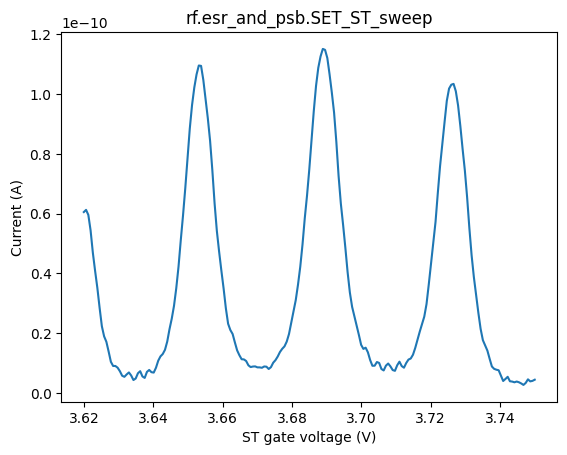

In [111]:
import swiper

low = 3.62
high = 3.75
pts = 201

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty)  # overlap points so we average

monty.save(result)

In [120]:
si.ST(3.683)

In [121]:
lockin.R()

6.9268230041e-11